장진혁 jinhyuk2ya@gmail.com

---

# 0. 데이터 수집 준비

### googlemaps API

In [ ]:
import googlemaps
gmaps_key = "****************************"
gmaps = googlemaps.Client(key=gmaps_key)

### DBManager

In [ ]:
import mysql.connector
import pandas as pd

class StoreDBManager :
    
    def __init__(self, host, port, user, password, database):
        self.host = host
        self.port = port
        self.user = user
        self.password = password
        self.database = database
        self.db = mysql.connector.connect(
            host=host,
            port=port,
            user=user,
            password=password,
            database=database
        )
        self.cursor = self.db.cursor(buffered=True)
        print("DB connected")

    def close(self):
        if self.cursor:
            self.cursor.close()
        if self.db:
            self.db.close()
        print("DB disconnected")

    def insert(self, table, store, address, latitude, longitude):
        try:
            sql = f"""INSERT INTO {table} VALUES(%s, %s, %s, %s)"""
            self.cursor.execute(sql, (store, address, latitude, longitude))
            self.db.commit()
            print("INSERTED")
            return True
        except:
            pass

    def select_all(self, table):
        sql = f"SELECT * FROM {table}"
        self.cursor.execute(sql)
        result = self.cursor.fetchall()
        columns = [col[0] for col in self.cursor.description]
        df = pd.DataFrame(result, columns=columns).reset_index(drop=True)
        return df

    def execute(self, sql):
        self.cursor.execute(sql)
        self.db.commit()
        print("------------------------------------------")
        print("EXECUTED")
        if self.cursor.description is not None:
            result = self.cursor.fetchall()
            print(result)
        return True
    
dbm = StoreDBManager(
    host="localhost",
    port= 3306,
    user="root",
    password="0000",
    database="mydb"
)

DB connected


### URLManager(API Manager)

In [ ]:
from urllib.request import Request, urlopen
import urllib.parse
from user_agent import generate_user_agent
from bs4 import BeautifulSoup
import json
    def genSearchUrl(self, api_node, search_text, start_num=None, disp_num=None):
        base = 'https://openapi.naver.com/v1/search'
        node = '/' + api_node + '.json'
        param_query = "?query=" + urllib.parse.quote(search_text)
        param_start = "&start=" + str(start_num) if start_num != None else ""
        param_disp = "&display=" + str(disp_num) if disp_num != None else ""
        return base + node + param_query + param_start + param_disp

    def getResultOnpage(self, url):
        request = urllib.request.Request(url)
        request.add_header("X-Naver-Client-Id",client_id)
        request.add_header("X-Naver-Client-Secret",client_secret)   
        response = urllib.request.urlopen(request)
        return json.loads(response.read().decode('utf-8'))

urm = URLManager()

URLManager Created


### AddressManager

In [ ]:
import urllib.parse
import re

class AdressManager :
    
    def __init__(self):
        print("AddressManager Created")
        
    
    def isDoro(self, address):
        parts = address.split()
        return any(re.search(r'(로|길)$', part) for part in parts)
    
    def isSeoul(self, address):
        return "서울" in address
    
    def extractDoro(self, address):
        match = re.search(r'[가-힣\d]+로\d*|[가-힣\d]+길\d*', address)
        return match.group() if match else ""
        
    def getDoro_byportal(self, query):
        url = "https://search.naver.com/search.naver?query=" + urllib.parse.quote(query)
        scm = ScrappingManager()
        scm.openPage(url)
        time.sleep(1)
        try:
            doro = scm.driver.find_element(By.ID, "no-matched-address-list").get_attribute('innerText')
            if self.isDoro(doro) == False : return ""
            return doro
        except:
            return ""
        finally:
            scm.driver.quit()
            
    # 네이버 API로 검색
    def getDoro_byapi(self, query):
        search_text = f"이디야커피 {query}"
        url = urm.genSearchUrl('local', search_text)
        result = urm.getResultOnpage(url)
        try: 
            doro = result['items'][0]['roadAddress']
            if self.isDoro(doro) == False : return ""
            return doro
        except:
            return ""
        
    # GOOGLE 맵 API를 통한 역지오코딩으로 주소 가져오기
    def getDoro_byrgc(self, lat, lng):
        result = gmaps.reverse_geocode((lat, lng), language='ko')[0]['formatted_address']
        if self.isDoro(result): return result
        else: return ""


    def getDoro(self, address, name=None, lat=None, lng=None):

        if self.isDoro(address):
            return address  # 이미 도로명 주소라면 그대로 반환
    
        # 네이버 API로 검색
        if name:
            doro = self.getDoro_byapi(name)
            if doro:
                return doro
        
        # 네이버 포털 검색 (Selenium)
        doro = self.getDoro_byportal(address)
        if doro:
            return doro
        
        # Google Maps API 역지오코딩 (위도, 경도 필요)
        if lat is not None and lng is not None:
            doro = self.getDoro_byRGC(lat, lng)
            if doro:
                return doro
        
        # 모든 방법을 시도했으나 도로명 주소를 찾지 못한 경우
        return ""

adm = AdressManager()

AddressManager Created


### ScrappingManager

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By

class ScrappingManager :
    
    def __init__ (self):
        self.driver = webdriver.Chrome(service=Service("/home/jinhyuk3me/dev_ws/eda/driver/chromedriver"))
        print("ScrappingManager Created")
        
    def openPage(self, url):
        if not self.driver : self.driver = webdriver.Chrome(service=Service("/home/jinhyuk3me/dev_ws/eda/driver/chromedriver"))
        self.driver.get(url)
        return True
    
    def getSoup(self, url, prefix=None) :
        try:
            if prefix :
                real_url = prefix + url
            real_url = url
            req = Request(url=real_url, headers={'User-Agent': generate_user_agent()})
            page = urlopen(req)
            soup = BeautifulSoup(page, "html.parser")
            return soup
        except:
            return None

---

### CREATE TABLE

In [153]:
dbm.execute("""create table starbucks(
    name varchar(32) NOT NULL PRIMARY KEY,
    address varchar(64) NOT NULL,
    latitude double,
    longitude double
)""")

------------------------------------------
EXECUTED


True

In [154]:
dbm.execute("""create table ediya(
    name varchar(32) NOT NULL PRIMARY KEY,
    address varchar(64) NOT NULL,
    latitude double,
    longitude double
)""")

------------------------------------------
EXECUTED


True

---

## 1. 스타벅스 매장 데이터 수집

In [157]:
from bs4 import BeautifulSoup
import time
import numpy as np
apiurl = "https://api.vworld.kr/req/address?"	


scm = ScrappingManager()
scm.openPage("https://www.starbucks.co.kr/store/store_map.do")
time.sleep(10)

button = scm.driver.find_element(By.CLASS_NAME, "loca_search")
button.click()
time.sleep(2)
button = scm.driver.find_element(By.CLASS_NAME, "set_sido_cd_btn")
button.click()
time.sleep(2)
button = scm.driver.find_element(By.CLASS_NAME, "set_gugun_cd_btn")
button.click()
time.sleep(2)

sb_html = scm.driver.page_source
sb_soup = BeautifulSoup(sb_html, "html.parser")
panel = sb_soup.find("ul", "quickSearchResultBoxSidoGugun")
stores = panel.find_all("li", "quickResultLstCon")

for idx, store in enumerate(stores) :
    name = store.find("strong").get('data-name')
    full_detail = store.find("p", "result_details").get_text()
    address = full_detail[:-9]
    geocode = gmaps.geocode(address)
    latitude = geocode[0].get("geometry")["location"]["lat"] if len(geocode) > 0 else np.nan
    longitude = geocode[0].get("geometry")["location"]["lng"] if len(geocode) > 0 else np.nan
    if adm.isDoro(address) == False : address = adm.getDoro(address, name, latitude, longitude) 
    dbm.insert("starbucks", name, address, latitude, longitude)
    print(f"[{idx}]")
    print(name)
    print(address)
    print(latitude)
    print(longitude)

ScrappingManager Created
INSERTED
[0]
역삼아레나빌딩
서울특별시 강남구 언주로 425 (역삼동)
37.5000776
127.0385419
INSERTED
[1]
논현역사거리
서울특별시 강남구 강남대로 538 (논현동)
37.5136787
127.0317124
INSERTED
[2]
신사역성일빌딩
서울특별시 강남구 강남대로 584 (논현동)
37.5136787
127.0317124
INSERTED
[3]
국기원사거리
서울특별시 강남구 테헤란로 125 (역삼동)
37.499615
127.0316758
INSERTED
[4]
대치재경빌딩
서울특별시 강남구 남부순환로 2947 (대치동)
37.4945248
127.062584
INSERTED
[5]
봉은사역
서울특별시 강남구 봉은사로 619 (삼성동)
37.5150389
127.0631304
INSERTED
[6]
압구정윤성빌딩
서울특별시 강남구 논현로 834 (신사동)
37.5228325
127.028577
INSERTED
[7]
코엑스별마당
서울특별시 강남구 영동대로 513 (삼성동)
37.5125207
127.0588194
INSERTED
[8]
삼성역섬유센터R
서울특별시 강남구 테헤란로 518 (대치동)
37.5074573
127.0606353
INSERTED
[9]
압구정R
서울특별시 강남구 언주로 861 (신사동)
37.52741049999999
127.0330945
INSERTED
[10]
수서역R
서울특별시 강남구 광평로 281 (수서동)
37.4880028
127.1026639
INSERTED
[11]
양재강남빌딩R
서울특별시 강남구 남부순환로 2621 (도곡동)
37.4853306
127.0366142
INSERTED
[12]
선릉동신빌딩R
서울특별시 강남구 테헤란로 409 (삼성동)
37.5054927
127.0504299
INSERTED
[13]
봉은사로선정릉
서울특별시 강남구 봉은사로 446 (삼성동)
37.5113321
127.0484374
INSERTED
[14]

---

## 2. 이디야 매장 데이터 수집

이디야 홈페이지에서 추출한 데이터의 경우 주소가 도로명 주소가 아닌 지번 주소임. 따라서 스타벅스 매장 주소와의 비교를 위해서 도로명 주소로의 변환이 필요한데, 이를 위해 `AddressManager.getDoro()`에서 `네이버 검색 API`, `네이버 포탈 검색(Selenium)`, `Geogle 역지오코딩 API`을 활용하였음.(모든 주소 입력에 대해서 대응하기 위해서 구현하였음)

또한, html을 추출할 때 중복된 데이터가 발생할 가능성이 높으므로 테이블의 `name` 컬럼을 `PRIMARY KEY`로 설정하여 중복된 데이터가 INSERT되는 것을 방지함.

In [ ]:
from bs4 import BeautifulSoup
import re
import time

scm = ScrappingManager()
gu_list = ['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', 
           '구로구', '금천구', '노원구', '도봉구', '동대문구', '동작구', 
           '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구', 
           '양천구', '영등포구', '용산구', '은평구', '종로구', '중구', '중랑구']
count = 0

for idx, gu in enumerate(gu_list):
    scm.driver.get("https://members.ediya.com/store")
    time.sleep(1)
    addr_btn = scm.driver.find_element(By.LINK_TEXT, "주소")
    addr_btn.click()
    addr_input = scm.driver.find_element(By.ID, "keyword")
    addr_input.send_keys(gu)
    search_btn = scm.driver.find_element(By.CLASS_NAME, "btn_search")
    search_btn.click()
    time.sleep(1)
    ed_html = scm.driver.page_source
    ed_soup = BeautifulSoup(ed_html, "html.parser")
    places = ed_soup.find_all("div", "st_li")
    for i, place in enumerate(places):
        name = re.sub(r"\s+", " ", place.find("h4", "name").get_text())
        address = re.sub(r"\s+", " ", place.find("p", "addr").get_text())
        tmp = address
        geocode = gmaps.geocode(address)
        latitude = geocode[0].get("geometry")["location"]["lat"] if len(geocode) > 0 else np.nan
        longitude = geocode[0].get("geometry")["location"]["lng"] if len(geocode) > 0 else np.nan
        if not adm.isSeoul(address) : continue
        if adm.isDoro(address) == False : address = adm.getDoro(address, name, latitude, longitude)
        print(f"<{count}>")
        print(f"{gu}: {i}번째 데이터")
        print(name)
        print(tmp)
        print(address)
        print(latitude)
        print(longitude)
        flag = dbm.insert("ediya", name, address, latitude, longitude)
        if flag : count += 1 # 실제로 INSERT가 일어났을 경우에만 count를 올림
scm.driver.quit()

ScrappingManager Created
<0>
강남구: 0번째 데이터
도산사거리점
서울특별시 강남구 언주로148길 14 나동 1층 107호
서울특별시 강남구 언주로148길 14 나동 1층 107호
37.5204069
127.0360954
INSERTED
<1>
강남구: 1번째 데이터
학동제마점
서울 강남구 학동로34길 22 (논현동) 
서울 강남구 학동로34길 22 (논현동) 
37.51313870000001
127.03365
INSERTED
<2>
강남구: 2번째 데이터
삼성대치점
서울 강남구 삼성로64길 32 (대치동, 주성빌딩) 1층
서울 강남구 삼성로64길 32 (대치동, 주성빌딩) 1층
37.5004196
127.0630716
INSERTED
<3>
강남구: 3번째 데이터
강남대치점
서울 강남구 역삼로 415 (대치동, 성진빌딩) 1층
서울 강남구 역삼로 415 (대치동, 성진빌딩) 1층
37.501434
127.052328
INSERTED
<4>
강남구: 4번째 데이터
강남율현점
서울 강남구 밤고개로21길 8 (율현동, 세곡프라자) 지상1층 104,105호
서울 강남구 밤고개로21길 8 (율현동, 세곡프라자) 지상1층 104,105호
37.4735822
127.1078311
INSERTED
<5>
강남구: 5번째 데이터
선릉역점
서울 강남구 테헤란로 332 (역삼동, 에이치제이타워) 이디야커피
서울 강남구 테헤란로 332 (역삼동, 에이치제이타워) 이디야커피
37.5038188
127.0481497
INSERTED
<6>
강남구: 6번째 데이터
한티역점
서울 강남구 도곡로69길 8 (대치동) 1층
서울 강남구 도곡로69길 8 (대치동) 1층
37.4979551
127.0561304
INSERTED
<7>
강남구: 7번째 데이터
청담역점
서울 강남구 삼성로 721 (청담동, 룩희 819) 1층
서울 강남구 삼성로 721 (청담동, 룩희 819) 1층
37.5200681
127.0491634
INSERTED
<8>
강남구: 8번째 데이터
강남구청역

---

# 3. 이디야 커피는 스타벅스 커피 매장 근처에 있는가?

In [4]:
sta_df = dbm.select_all("starbucks")
edi_df = dbm.select_all("ediya")

## 1) `Folium`을 통한 시각화

매장이 너무 많아서 특징이 잘 보이지 않는다. 수치적으로 해석해보는 것이 이해하기 더 쉬울 듯하다.

In [5]:
import folium
import numpy as np

mapping = folium.Map(location=[37.5665, 126.9780], zoom_start=12)

for idx, row in edi_df.iterrows():
    if np.isnan(row['latitude']) or np.isnan(row['longitude']):
        continue
    folium.Marker(
        [row['latitude'], row['longitude']], 
        icon=folium.Icon(color='blue'), popup="이디야커피 "+row['name']
    ).add_to(mapping)

for idx, row in sta_df.iterrows():
    if np.isnan(row['latitude']) or np.isnan(row['longitude']):
        continue
    folium.Marker(
        [row['latitude'], row['longitude']], 
        icon=folium.Icon(color='green'), popup="스타벅스 "+row['name']
    ).add_to(mapping)

mapping

## 2) 물리적 거리 분석

### (1) `Haversine 공식`을 이용한 거리 계산

Haversine 공식은 구형 지구를 가정하고 두 점 사이의 대원(최단거리)을 계산하는 공식이다.

In [ ]:
import numpy as np
from geopy.distance import great_circle

def haversine(lat1, lon1, lat2, lon2):
    R = 6371 * 1000
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi/2.0)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R*c

starbucks_coords = [(lat, lng) for lat, lng in zip(sta_df['latitude'], sta_df['longitude'])]
ediya_coords = [(lat, lng) for lat, lng in zip(edi_df['latitude'], edi_df['longitude'])]



distance_results = []

for ediya in ediya_coords:
    ediya_lat, ediya_lng = ediya
    distances = [haversine(ediya_lat, ediya_lng, star_lat, star_lng) for star_lat, star_lng in starbucks_coords]
    min_distance = min(distances)  # 가장 가까운 스타벅스 매장과의 거리
    distance_results.append(min_distance)

thresholds = [100, 300, 500]
for threshold in thresholds:
    nearby_count = sum(1 for d in distance_results if d <= threshold)
    total_ediya = len(distance_results)
    print(f"{threshold}m 이내에 있는 이디야 매장 비율: {nearby_count / total_ediya:.2%}")


100m 이내에 있는 이디야 매장 비율: 15.32%
300m 이내에 있는 이디야 매장 비율: 47.94%
500m 이내에 있는 이디야 매장 비율: 68.37%


### (2) `KDTree`를 이용한 최근접 매장 거리 계산

In [277]:
starbucks_coords = [(lat, lng) for lat, lng in zip(sta_df['latitude'], sta_df['longitude'])]
ediya_coords = [(lat, lng) for lat, lng in zip(edi_df['latitude'], edi_df['longitude'])]

In [ ]:
from geopy.distance import great_circle

# KDTree 생성
starbucks_tree = KDTree(np.radians(starbucks_coords))

# 최근접 스타벅스 거리 계산
distances, indices = starbucks_tree.query(np.radians(ediya_coords))
distances = distances * 6371 * 1000  # 6371 : 지구반지름, 1000: 단위변환

# 100m, 300m, 500m 이내 이디야 매장 수 계산
thresholds = [100, 300, 500]
for threshold in thresholds:
    count = np.sum(distances < threshold)
    print(f"{threshold}m 이내에 있는 이디야 매장 개수: {count} / {len(ediya_coords)} ({count / len(ediya_coords) * 100:.2f}%)")


100m 이내에 있는 이디야 매장 개수: 65 / 509 (12.77%)
300m 이내에 있는 이디야 매장 개수: 218 / 509 (42.83%)
500m 이내에 있는 이디야 매장 개수: 323 / 509 (63.46%)


## 4) 도로명 주소 비교

상권 분석의 정확성을 높이기 위해서는 행정구 단위보다는 보다 세분화된 도로명 주소 단위를 기준으로 분석하는 것이 더욱 적합하다.

In [192]:
edi_df['doro'] = edi_df['address'].apply(adm.extractDoro)
sta_df['doro'] = sta_df['address'].apply(adm.extractDoro)
edi_df['doro'] = [re.sub(r'\d+$', '', doro) for doro in edi_df['doro']]
sta_df['doro'] = [re.sub(r'\d+$', '', doro) for doro in sta_df['doro']]

In [201]:
edi_dorocounts = edi_df['doro'].value_counts()
sta_dorocounts = sta_df['doro'].value_counts()

doro_counts_df = pd.merge(
    edi_dorocounts.to_frame(name="edi_count"), 
    sta_dorocounts.to_frame(name="sta_count"),
    left_index=True, 
    right_index=True, 
    how="outer"
).fillna(0)

doro_counts_df

,edi_count,sta_count
doro,,
19로,1.0,0.0
63로,1.0,0.0
가락로,1.0,0.0
가로,0.0,1.0
가로공원로,1.0,0.0
...,...,...
효령로,1.0,1.0
효창원로,1.0,0.0
후암로,1.0,0.0


중간 정도의 양의 상관관계가 있다. (0.6936721165295652)

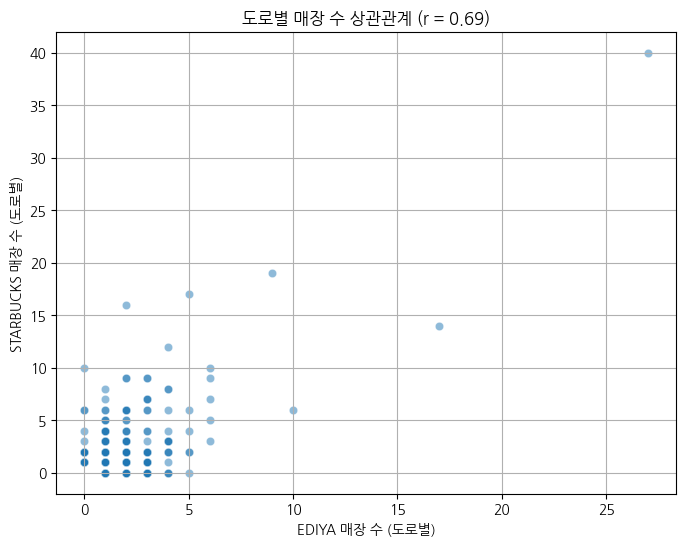

np.float64(0.6936721165295652)

In [207]:
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

# 피어슨 상관계수 계산
correlation = doro_counts_df['edi_count'].corr(doro_counts_df['sta_count'])

# 산점도 시각화
plt.figure(figsize=(8, 6))
sns.scatterplot(x=doro_counts_df['edi_count'], y=doro_counts_df['sta_count'], alpha=0.5)
plt.xlabel("EDIYA 매장 수 (도로별)")
plt.ylabel("STARBUCKS 매장 수 (도로별)")
plt.title(f"도로별 매장 수 상관관계 (r = {correlation:.2f})")
plt.grid(True)

# 차트 출력
plt.show()

# 상관계수 출력
correlation

---

# 4. 결론

## 4-1) 거리 기반 분석 결과

`Haversine 공식`에 의한 거리계산과 `KDTree`를 이용한 거리계산의 결과 유사한 것으로 보아 계산에는 큰 오차가 없는 듯 보임.

- `100m 이내` : 12~15% 정도의 이디야 매장만 스타벅스와 가까이 위치

- `300m 이내`: 42~47% 정도의 이디야 매장이 스타벅스 300m 반경 내에 있음

- `500m 이내`: 63~68%의 이디야 매장이 스타벅스 반경 500m 내에 위치

극단적인 근접 전략보다는 **어느 정도 분리된 입점 전략**을 취하는 듯 보임

**약 65% 정도의 이디야 매장이 스타벅스와 같은 상권을 공유**한다고 볼 수 있음.

## 4-2) 상관계수 분석 결과

도로별 이디야 매장과 스타벅스 매장의 상관계수 분석 결과, 0.6937 정도의 상관계수를 보여주었음.

- 0.6937의 상관계수는 `중간 정도의 상관관계~강한 상관관계`를 의미함

- 즉, 이디야 매장이 많은 도로에서는 스타벅스 매장도 많을 가능성이 높음.

## 4-3) 결론

이디야 매장과 스타벅스 매장은 같은 상권을 공유하는 경향을 보이며, 이는 두 브랜드가 유동 인구가 많은 지역을 공략하는 전략을 취하고 있다고 볼 수 있음. 특히, 매장들이 300~500m 이내에 있는 경우가 많아, 같은 상권/생활권 내에서 경쟁할 가능성이 높음.

**그러나 다른 요인(유동 인구, 오피스/주거지 밀집도, 역세권 여부 등)도 입점 전략에 영향이 미칠 가능성이 크므로, 직접적인 인과관계를 단정하기는 어려우며 추가적인 분석이 반드시 필요함.**

---